In [1]:
import matplotlib.gridspec as gridspec
import scqubits
import numpy as np
from CoupledQuantumSystems.visualization import *
from CoupledQuantumSystems.systems import *
from tqdm import tqdm
from CoupledQuantumSystems.qobj_manip import *
from CoupledQuantumSystems.drive import *
from  IPython.display import  clear_output
import matplotlib.ticker as ticker

In [2]:
max_ql = 13
max_tl = 4 
EJ_over_EC = 2
EJ_over_EL = 30
fluxonium = scqubits.Fluxonium(EJ = 4,EC = 4/EJ_over_EC,EL = 4/EJ_over_EL, cutoff = 110,flux = 0,truncated_dim=max_ql)

In [31]:
def get_shift_accurate(ele,omega_i, omega_j, omega_r):
    return abs(ele)**2 / (omega_j-omega_i-omega_r) - abs(ele)**2 / (omega_i-omega_j-omega_r)

def plot_chi_curve(ax, Er_array, shift_array, label, color, linestyle, linewidth):
    from scipy.signal import find_peaks
    shifts = np.array(shift_array)
    Er_array = np.array(Er_array)

    # Find discontinuities
    diff_shifts = np.abs(np.diff(shifts))
    peaks, _ = find_peaks(diff_shifts)
    filtered_peaks = peaks[diff_shifts[peaks] > 1]

    # Plot vertical dashed lines at discontinuities
    for peak in filtered_peaks:
        ax.axvline(x=Er_array[peak], color=color, linestyle='--', alpha=0.8, linewidth=linewidth)

    # Split data into segments
    split_indices = np.concatenate(([0], filtered_peaks + 1, [len(shifts)]))

    for i in range(len(split_indices) - 1):
        start = split_indices[i]
        end = split_indices[i + 1]
        ax.plot(Er_array[start:end], shifts[start:end], color=color, linestyle=linestyle, linewidth=linewidth)

    # Add label only once for the first segment (optional)
    ax.plot([], [], color=color, linestyle=linestyle, linewidth=linewidth, label=label)

    
def plot_sweep_er(ax,qbt=fluxonium,g=1,Er_array = np.linspace(2,15,int(1e4)),ymin=-3,ymax=3,x_offset=0,y_offset=0,labeled_transitions=[(0,2),(0,3),(2,3)]):
    qls = [0,2,3]
    colors = ['#4999c3','#6cbe80','orange']
    labels = [r'$\chi_g$',r'$\chi_f$',r'$\chi_h$']
    n_evals = max_ql
    matrix =  qbt.matrixelement_table(operator = "n_operator",evals_count=n_evals)
    evals = qbt.eigenvals(n_evals)
    for ql, label, color in zip(qls, labels, colors):
        shift_from_qubit_transition = []
        for Er in tqdm(Er_array, desc = "Er loop"):
            shifts = [get_shift_accurate(matrix[ql,ql2], evals[ql2], evals[ql], Er) for ql2 in range(n_evals)] 
            shift_from_qubit_transition.append(sum(shifts)/100 * g * 1000)
        plot_chi_curve(ax,Er_array,np.array(shift_from_qubit_transition),label=label,color = color, linestyle = '-',linewidth = 1.5)
    ax.grid(which='major', linestyle=':', linewidth='0.5', color='black')
    ax.set_xlim(Er_array[0],Er_array[-1])
    ax.set_ylim(ymin,ymax)
    ax.legend(loc= 'upper left')
    ax.set_xlabel(r"$\omega_r (GHz/2\pi$)")
    ax.set_yticklabels([f'{val:.1f}' for val in ax.get_yticks()])
    ax.set_ylabel(r'$\chi (MHz/2\pi)$')
    # for transition in labeled_transitions:
    #     x = np.abs(evals[transition[1]]-evals[transition[0]]+x_offset)
    #     y = y_offset
    #     ax.text(x,y,f"{transition[0]}-{transition[1]}",color = colors[transition[1]],fontweight='bold')



def get_detection_results(x):
    import os
    import pickle
    cache_name = f"{x}_transmon_detection.pkl"
    # if cache exist
    if not os.path.exists(cache_name):
        EJ = x[0]
        amp = x[1]
        t_duration = x[2]
        tlist = np.linspace(0,t_duration,1000)

        transmon = scqubits.Transmon(
            EJ= EJ,
            EC=0.5,
            ng=0.0,
            ncut=10,
            truncated_dim = max_tl
            )

        system = FluxoniumTransmonSystem(
            fluxonium  = fluxonium,
            transmon = transmon,
            computaional_states = '0,2',
            g_strength = 0.1,
            )
        driven_op = qutip.Qobj(system.hilbertspace.op_in_dressed_eigenbasis(transmon.n_operator)[:, :])

        e_ops = []
        for ql in range(max_ql):
            for tl in range(max_tl):
                e_ops.append(system.truncate_function(qutip.ket2dm(qutip.basis(system.hilbertspace.dimension, system.product_to_dressed[(ql,tl)]))))

        results  = system.run_qutip_mesolve_parrallel(
            initial_states = [qutip.basis(system.hilbertspace.dimension, system.product_to_dressed[(ql,0)]) for ql in [0,2,3,1]],
            tlist = tlist,
            drive_terms = [DriveTerm( 
                                driven_op= driven_op,
                                pulse_shape_func=square_pulse_with_rise_fall,
                                pulse_id = 'sdaas',
                                pulse_shape_args={
                                    'w_d': system.evals[system.product_to_dressed[(3,1)]] - system.evals[system.product_to_dressed[(3,0)]] ,
                                    'amp': amp,
                                    't_square': 1000
                                })],
            # c_ops = c_ops,
            e_ops =  e_ops
        )
        with open(cache_name,'wb') as f:
            pickle.dump((results,tlist),f)
    else:
        with open(cache_name,'rb') as f:
            results,tlist =pickle.load(f)
    return results, tlist

def plot_detection_results(results,tlist, axes):
    assert len(axes)==3
    alpha=0.6
    for i, (result,ql,ql_label) in enumerate(zip(results,[0,2,3],['g','f','h'])):
        line, =axes[i].plot(tlist,result.expect[ql*max_tl+0],label= rf"$\langle${ql_label}$_f0_t\rangle$",alpha=alpha)
        axes[i].text(tlist[200],result.expect[ql*max_tl+0][200],s= rf"{ql_label}$_f0_t$",va='top',ha='center',color=line.get_color(),size=12)

        line, =axes[i].plot(tlist,result.expect[ql*max_tl+1],label= rf"$\langle${ql_label}$_f1_t\rangle$",alpha=alpha)
        axes[i].text(tlist[-300],result.expect[ql*max_tl+1][-300],s= rf"{ql_label}$_f1_t$",va='top',ha='center',color=line.get_color(),size=12)

        line, =axes[i].plot(tlist,result.expect[ql*max_tl+2],label= rf"$\langle${ql_label}$_f2_t\rangle$",alpha=alpha)
        if i == 0 or i ==1:
            axes[i].text(tlist[-500],result.expect[ql*max_tl+2][-500],s= rf"{ql_label}$_f2_t$",va='bottom',ha='center',color=line.get_color(),size=12)
        else:
            axes[i].text(tlist[-100],result.expect[ql*max_tl+2][-100],s= rf"{ql_label}$_f2_t$",va='bottom',ha='center',color=line.get_color(),size=12)

        axes[i].set_yscale('log')
        axes[i].set_ylim(8e-5,2)

        # Major and minor ticks for logarithmic scale
        axes[i].yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=10))  # Set major ticks
        axes[i].yaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs='auto', numticks=10))  # Set minor ticks

        axes[i].grid(which='major', linestyle='-')  # Solid grid lines for major ticks
        axes[i].grid(which='minor', linestyle='--',alpha=0.2)  # Dashed grid lines for minor ticks

    for i in [0,1,2]:
        axes[i].set_xlabel(f"t (ns)")
    axes[0].set_ylabel('Population')
    axes[1].set_ylabel('')
    axes[1].set_yticklabels([])
    axes[2].set_ylabel('')
    axes[2].set_yticklabels([])

Er loop: 100%|██████████| 10000/10000 [00:00<00:00, 136707.33it/s]
 /tmp/ipykernel_402956/1168634200.py: 48

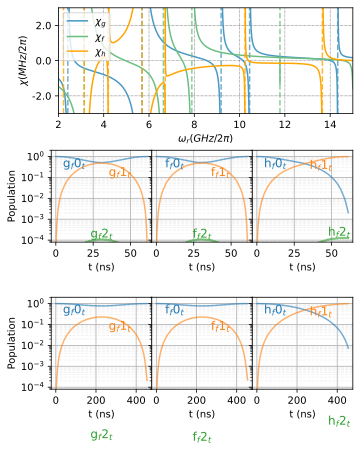

In [32]:
fig = plt.figure(figsize=(5, 6.4)) 

gs_chi = fig.add_gridspec(1,1,left=0.17,right=0.99,bottom=0.75,top=0.98)
ax = fig.add_subplot(gs_chi[0])
plot_sweep_er(ax)

left = 0.15
l = 0.28

bottom_7GHz = 0.15
top_7GHz = 0.35
gs0_7GHz = fig.add_gridspec(nrows=1, ncols=1,left=left, right=left+l,
                       bottom=bottom_7GHz,top = top_7GHz)
gs1_7GHz = fig.add_gridspec(nrows=1, ncols=1,left=left+l, right=left+l*2,
                       bottom=bottom_7GHz,top = top_7GHz)
gs2_7GHz = fig.add_gridspec(nrows=1, ncols=1,left=left+l*2, right=left+l*3,
                       bottom=bottom_7GHz,top = top_7GHz)
axes_7GHz = [fig.add_subplot(gs0_7GHz[0]),
        fig.add_subplot(gs1_7GHz[0]),
        fig.add_subplot(gs2_7GHz[0])]

bottom_13GHz = 0.47
top_13GHz = 0.67
gs0_13GHz = fig.add_gridspec(nrows=1, ncols=1,left=left, right=left+l,
                       bottom=bottom_13GHz,top = top_13GHz)
gs1_13GHz = fig.add_gridspec(nrows=1, ncols=1,left=left+l, right=left+l*2,
                       bottom=bottom_13GHz,top = top_13GHz)
gs2_13GHz = fig.add_gridspec(nrows=1, ncols=1,left=left+l*2, right=left+l*3,
                       bottom=bottom_13GHz,top = top_13GHz)
axes_13GHz = [fig.add_subplot(gs0_13GHz[0]),
        fig.add_subplot(gs1_13GHz[0]),
        fig.add_subplot(gs2_13GHz[0])]


x_13GHz = [5.02309745e+01, 8.70320763e-03 , 6.11312288e+01]
x_7GHz = x = [1.49827404e+01, 1.09403029e-03, 4.54907550e+02]
results_13GHz,tlist_13GHz = get_detection_results(x_13GHz)
results_7GHz,tlist_7GHz = get_detection_results(x_7GHz)
plot_detection_results(results_13GHz,tlist_13GHz,axes_13GHz)
plot_detection_results(results_7GHz,tlist_7GHz,axes_7GHz)

plt.show()
fig.savefig('detect3.pdf')